# High Resolution Notebook HBC722

### Summer 2019

Modified 27 January 2021. Will serve as a way to package my FU Ori modeling routine into a format for others to use and build upon. Will be put on GitHub as $\texttt{AccDiskSpec}$

### Imports 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
import scipy.signal as signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import spectres
from astropy.io import fits

### Constants 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

### Directory to stellar atmospheres library

In [126]:
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/HiResStellarAtms/'
ATM_TABLE = dict()
ATMOS_FACTOR = 100

### Rotational Broadening

In [127]:
from __future__ import print_function, division
import numpy as np
from PyAstronomy.pyaC import pyaErrors as PE
import six.moves as smo

class _Gdl:
  
  def __init__(self, vsini, epsilon):
    """
      Calculate the broadening profile.
      
      Parameters
      ----------
      vsini : float
          Projected rotation speed of the star [km/s]
      epsilon : float
          Linear limb-darkening coefficient
    """
    self.vc = vsini / 299792.458
    self.eps = epsilon
  
  def gdl(self, dl, refwvl, dwl):
    """
      Calculates the broadening profile.
      
      Parameters
      ----------
      dl : array
          'Delta wavelength': The distance to the reference point in
          wavelength space [A].
      refwvl : array
          The reference wavelength [A].
      dwl : float
          The wavelength bin size [A].
      
      Returns
      -------
      Broadening profile : array
          The broadening profile according to Gray. 
    """
    self.dlmax = self.vc * refwvl
    result = np.zeros(len(dl))
    x = dl/self.dlmax
    indi = np.where(np.abs(x) < 1.0)[0]
#     result[indi] = self.c1*np.sqrt(1. - x[indi]**2) + self.c2*(1. - x[indi]**2)
    result[indi] = (1/(np.pi*self.dlmax))*(1. - (x[indi])**2)**(-0.5)
    
    # Correct the normalization for numeric accuracy
    # The integral of the function is normalized, however, especially in the case
    # of mild broadening (compared to the wavelength resolution), the discrete
    # broadening profile may no longer be normalized, which leads to a shift of
    # the output spectrum, if not accounted for.
    result /= (np.sum(result) * dwl)
    return result
  

def rotBroad(wvl, flux, epsilon, vsini, edgeHandling="firstlast"):
  """
    Apply rotational broadening to a spectrum.
    
    This function applies rotational broadening to a given
    spectrum using the formulae given in Gray's "The Observation
    and Analysis of Stellar Photospheres". It allows for
    limb darkening parameterized by the linear limb-darkening law.
    
    The `edgeHandling` parameter determines how the effects at
    the edges of the input spectrum are handled. If the default
    option, "firstlast", is used, the input spectrum is internally
    extended on both sides; on the blue edge of the spectrum, the
    first flux value is used and on the red edge, the last value
    is used to extend the flux array. The extension is neglected
    in the return array. If "None" is specified, no special care
    will be taken to handle edge effects.
    
    .. note:: Currently, the wavelength array as to be regularly
              spaced.
    
    Parameters
    ----------
    wvl : array
        The wavelength array [A]. Note that a
        regularly spaced array is required.
    flux : array
        The flux array.
    vsini : float
        Projected rotational velocity [km/s].
    epsilon : float
        Linear limb-darkening coefficient (0-1).
    edgeHandling : string, {"firstlast", "None"}
        The method used to handle edge effects.
    
    Returns
    -------
    Broadened spectrum : array
        An array of the same size as the input flux array,
        which contains the broadened spectrum.
  """
  # Check whether wavelength array is evenly spaced
  sp = wvl[1::] - wvl[0:-1]
  if abs(max(sp) - min(sp)) > 1e-6:
    raise(PE.PyAValError("Input wavelength array is not evenly spaced.",
                         where="pyasl.rotBroad",
                         solution="Use evenly spaced input array."))
  if vsini <= 0.0:
    raise(PE.PyAValError("vsini must be positive.", where="pyasl.rotBroad"))
  if (epsilon < 0) or (epsilon > 1.0):
    raise(PE.PyAValError("Linear limb-darkening coefficient, epsilon, should be '0 < epsilon < 1'.",
                         where="pyasl.rotBroad",
                         solution="Adapt epsilon."))
  
  # Wavelength binsize
  dwl = wvl[1] - wvl[0]
  
  # Indices of the flux array to be returned
  validIndices = None
  
  if edgeHandling == "firstlast":
    # Number of bins additionally needed at the edges 
    binnu = int(np.floor(((vsini / 299792.458) * max(wvl)) / dwl)) + 1
    # Defined 'valid' indices to be returned
    validIndices = np.arange(len(flux)) + binnu
    # Adapt flux array
    front = np.ones(binnu) * flux[0]
    end = np.ones(binnu) * flux[-1]
    flux = np.concatenate( (front, flux, end) )
    # Adapt wavelength array
    front = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wvl = np.concatenate( (front, wvl, end) )
  elif edgeHandling == "None":
    validIndices = np.arange(len(flux))
  else:
    raise(PE.PyAValError("Edge handling method '" + str(edgeHandling) + "' currently not supported.",
                         where="pyasl.rotBroad",
                         solution="Choose ones of the valid edge handling methods"))
    
  
  result = np.zeros(len(flux))
  gdl = _Gdl(vsini, epsilon)
  
  for i in smo.range(len(flux)):
    dl = wvl[i] - wvl
    g = gdl.gdl(dl, wvl[i], dwl)
    result[i] = np.sum(flux * g)
  result *= dwl
  
  return result[validIndices]



Reading stellar atmospheres into a grid for quick calculation.

In [128]:
def direcToArray(directory, atmos_lib):
        if atmos_lib == 'NextGenHiRes':
            for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
                for grav in [1.5, 4.0]:
                    try:
                        atmos_file = directory + 'lte0' + str(int(temp/ATMOS_FACTOR)) \
                                + '-' + str(grav) + '-0.0a+0.0.BT-NextGen.7.dat.txt'
                        txt = open(atmos_file)
                        fulltxt = txt.readlines()
                        # Cleaning lines
                        newtxt = []
                        for i in range(8, len(fulltxt)):
                            line = fulltxt[i][:-1]
                            line = line.split()
                            newtxt.append(line)

                        # Casting as floats
                        newtxt = np.array(newtxt).astype(np.float64)

                        # Choosing which model to use
                        wav, lum = newtxt[:,0], newtxt[:,1]*1e8
                        ATM_TABLE[(temp, grav)] = np.array([wav, lum])
                    except:
                        print('No atmosphere found for temp = ' + str(temp) + \
                              ' grav = ' + str(grav))
        elif atmos_lib == 'NextGen':
            for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
                for grav in [1.5, 4.0]:
                    try:
                        atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                                + '-' + str(grav) + '-0.0.spec'
                        txt = open(atmos_file)
                        fulltxt = txt.readlines()
                        # Cleaning lines
                        newtxt = []
                        for i in range(len(fulltxt)):
                            line = fulltxt[i][:-1]
                            line = line.split()
                            newtxt.append(line)

                        # Casting as floats
                        newtxt = np.array(newtxt).astype(np.float64)

                        # Choosing which model to use
                        wav, lum = newtxt[:,0], newtxt[:,1]
                        ATM_TABLE[(temp, grav)] = np.array([wav, lum])
                    except:
                        print('No atmosphere found for temp = ' + str(temp) + \
                              ' grav = ' + str(grav))
        else:
            print('Atmosphere library not found.')

In [129]:
direcToArray(DIREC, 'NextGenHiRes')

No atmosphere found for temp = 2000 grav = 1.5
No atmosphere found for temp = 2000 grav = 4.0
No atmosphere found for temp = 2100 grav = 1.5
No atmosphere found for temp = 2100 grav = 4.0
No atmosphere found for temp = 2200 grav = 1.5
No atmosphere found for temp = 2200 grav = 4.0
No atmosphere found for temp = 2300 grav = 1.5
No atmosphere found for temp = 2300 grav = 4.0
No atmosphere found for temp = 2400 grav = 1.5
No atmosphere found for temp = 2400 grav = 4.0
No atmosphere found for temp = 2500 grav = 1.5
No atmosphere found for temp = 2500 grav = 4.0
No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere

## Making an instance of the class FU Ori and testing

In [130]:
ATM_TABLE[(5000, 4.0)][0][90000:90020]

array([4752.55, 4752.57, 4752.58, 4752.62, 4752.63, 4752.66, 4752.67,
       4752.69, 4752.71, 4752.72, 4752.74, 4752.77, 4752.79, 4752.82,
       4752.82, 4752.84, 4752.87, 4752.9 , 4752.92, 4752.97])

In [131]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        self.disk_atm = []
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc, atm_table):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(9700, 2000, 100, 1*r_star)
#         fuori.r_a, fuori.r_b, fuori.temps = makeMod(fuori.r_a, fuori.r_b, fuori.temps, bins=20)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=0.025, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc, atm_table):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v, atm_table) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 0.025, 'linear')
        self.rot_star.broadenStellarSpectrum()
        
    def createDiskAtm(self, temp, grav, vsini, direc, atm_table):
        disk_atm = DiskAtmosphere(temp, grav, vsini, direc, atm_table) 
        disk_atm.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        disk_atm.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 0.025, 'linear')
        disk_atm.broadenDiskAtmSpectrum()
        self.disk_atm.append(disk_atm)
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'disk atmosphere':
            return self.disk_atm[obj_num].getLuminosity(wave_lower, wave_upper, 'broadened')
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [132]:
def t_max(mass, radius, acc_rate):
    return 13000*(mass)**(1/4)*(10**acc_rate/1e-5)**(1/4)*(radius)**(-3/4)

def v_max(mass, radius, inc):
    return np.sqrt(G*mass*M_SUN/(radius*R_SUN))*np.sin(np.radians(inc))*1e-5

def lum_max(mass, radius, acc_rate):
    return G*mass*M_SUN*(10**acc_rate * M_SUN/sec_YEAR)/(2*radius*R_SUN)/L_SUN

In [14]:
400/5.7

70.17543859649122

In [15]:
np.sin(np.radians(30))/np.sin(np.radians(5))

5.736856622834927

In [138]:
PARAMS = [1.39/2, 1.39, -5.50, 3.16, 30, 0]
PARAMS_2 = [1.39/2, 1.39, -5.50, 3.16, 20, 0]
# PARAMS_3 = [0.56, 1.39, -5.41, 3.16, 20, 0]

In [139]:
t_max(PARAMS[0], PARAMS[1], PARAMS[2]), t_max(PARAMS_2[0], PARAMS_2[1], PARAMS_2[2])

(6953.099644220367, 6953.099644220367)

In [140]:
v_max(PARAMS[0], PARAMS[1], PARAMS[-2]), v_max(PARAMS_2[0], PARAMS_2[1], PARAMS_2[-2])

(154.42732372148916, 105.63451078524633)

In [141]:
lum_max(PARAMS[0], PARAMS[1], PARAMS[2]), lum_max(PARAMS_2[0], PARAMS_2[1], PARAMS_2[2])

(24.79171913239512, 24.79171913239512)

In [142]:
6720-100

6620

In [187]:
gaia17bpi_env = FUOriEnvironment(5.05e3, 5.15e3, 0, 0)


R_OUTER = 70*R_SUN
DIST = 795*3.08567758128e18
# Spectrum fit

%time gaia17bpi_env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC,  atm_table=ATM_TABLE)

%time gaia17bpi_env.createFUOri(r_star = PARAMS_2[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS_2[0]*M_SUN,\
                          m_dot = (10**PARAMS_2[2]) * M_SUN / 3.154e7, inc = PARAMS_2[4],\
                                a_v = PARAMS_2[3],dist = DIST, grav = 1.5, \
                                direc = DIREC,  atm_table=ATM_TABLE)

# %time gaia17bpi_env.createFUOri(r_star = PARAMS_3[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS_3[0]*M_SUN,\
#                           m_dot = (10**PARAMS_3[2]) * M_SUN / 3.154e7, inc = PARAMS_3[4],\
#                                 a_v = PARAMS_3[3],dist = DIST, grav = 1.5, \
#                                 direc = DIREC,  atm_table=ATM_TABLE)



Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6900.
Used stellar atmosphere at T = 6800.
Used stellar atmosphere at T = 6700.
Used stellar atmosphere at T = 6600.
Used stellar atmosphere at T = 6500.
Used stellar atmosphere at T = 6400.
Used stellar atmosphere at T = 6300.
Used stellar atmosphere at T = 6200.
Used stellar atmosphere at T = 6100.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5900.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5700.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5500.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5300.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5100.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4900.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4700.
U

/Users/tonyrodriguez/Documents/Docs/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:133: RuntimeWarning: divide by zero encountered in power
  term1 = 2*h_PLANCK*(c_LIGHT**2)*(wavelength**(-5))*np.pi
/Users/tonyrodriguez/Documents/Docs/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:134: RuntimeWarning: divide by zero encountered in true_divide
  term2 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)
/Users/tonyrodriguez/Documents/Docs/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:134: RuntimeWarning: overflow encountered in exp
  term2 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)
/Users/tonyrodriguez/Documents/Docs/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:135: RuntimeWarning: invalid value encountered in multiply
  return (wavelength, term1*term2)


No stellar atmosphere for annulus of T = 2400. Used blackbody.
No stellar atmosphere for annulus of T = 2300. Used blackbody.
No stellar atmosphere for annulus of T = 2200. Used blackbody.
No stellar atmosphere for annulus of T = 2100. Used blackbody.
No stellar atmosphere for annulus of T = 2000. Used blackbody.
No stellar atmosphere for annulus of T = 1898. Used blackbody.
No stellar atmosphere for annulus of T = 1804. Used blackbody.
No stellar atmosphere for annulus of T = 1720. Used blackbody.
No stellar atmosphere for annulus of T = 1645. Used blackbody.
No stellar atmosphere for annulus of T = 1577. Used blackbody.
No stellar atmosphere for annulus of T = 1516. Used blackbody.
No stellar atmosphere for annulus of T = 1460. Used blackbody.
No stellar atmosphere for annulus of T = 1408. Used blackbody.
No stellar atmosphere for annulus of T = 1361. Used blackbody.
No stellar atmosphere for annulus of T = 1317. Used blackbody.
No stellar atmosphere for annulus of T = 1276. Used bla

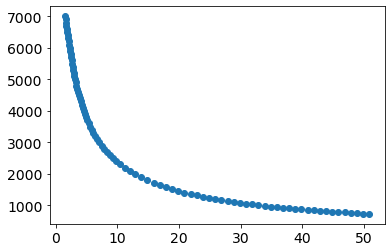

In [188]:
plt.plot(gaia17bpi_env.fuori[0].r_b/gaia17bpi_env.fuori[0].r_star, gaia17bpi_env.fuori[0].temps, 'o')

#  Data

In [3]:
testobject = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Data/HBC 722/Hires/ptf10qpf_20160520'
rvobject = +4.5



image, header = fits.getdata(testobject+'_1.fits',header=True)
ccdMax1 = np.shape(image)[0]
image, header = fits.getdata(testobject+'_2.fits',header=True)
ccdMax2 = np.shape(image)[0]
image, header = fits.getdata(testobject+'_3.fits',header=True)
ccdMax3 = np.shape(image)[0]

# with the routine read_spectrum looking like this:

def read_spectrum(star_name, ccd_num, n, wRange=[], section=False, entire=False, plot=False): 
    
    # add wavelength range parameter  <--- is this not wRange?
    # add glob to plot all three ccds at once
    
    '''Read one file and plot spectrum. Order number n must be ≥ 1 and can plot either one 
    order or entire spectrum.

    Ex: read_spectrum('ptf10qpf_20160520', 1, 4, section=False, entire=True) plots all orders
    '''
    if (wRange == [] or wRange == [-1, -1]) and entire == False:
        section = True
    filename = '{0}_{1}.fits'.format(star_name, ccd_num)
    image,header = fits.getdata(filename,header=True) #extracts image values and header
    number = n-1 #to account for python counting system
    if section or (wRange != [] and wRange != [-1,-1]): #plots one order for one file
        if n<=9:
            start_wav = header['CRVL1_0{0:}'.format(n)]  #extracts starting wavelength value for one order
            step = header['CDLT1_0{0:}'.format(n)] #extracts step value for one order
        if n>9: #this deals with the CR..._0n vs CR..._10 one digit/two digit issue
            start_wav = header['CRVL1_{0:}'.format(n)]
            step = header['CDLT1_{0:}'.format(n)]
        wave = np.arange(len(image[number]))*step+start_wav # combines evenly spaced values in length of the image 
        # in that order, then multiplies by step and adds start wavelength to create a set of reasonable wavelengths
        waveSection = np.copy(wave)
        if wRange != [] and wRange != [-1,-1]:
            minWavelength = min(wRange)
            maxWavelength = max(wRange)
            if minWavelength < min(wave) or minWavelength > max(wave):
                raise ValueError('Minimum wavelength out of bounds,\n'
                                 + 'wavelength range: {0}, order range: {1}'.format(wRange,[min(wave),max(wave)]))
            elif maxWavelength < min(wave) or maxWavelength > max(wave):
                raise ValueError('Maximum wavelength out of bounds,\n'
                                 + 'wavelength range: {0}, order range: {1}'.format(wRange,[min(wave),max(wave)]))
            newWaveRange = np.where(np.logical_and(wave >= minWavelength, wave <= maxWavelength))[0]
            wave = wave[newWaveRange]
            minIndex = int((minWavelength - start_wav) / step)
            maxIndex = int((maxWavelength - start_wav) / step)
            if plot:
              # print('minIndex = {0}, maxIndex = {1}, length = {2}'.format(minIndex, maxIndex, len(image[number])))
                plt.ion()
                plt.figure(figsize=(8,6))
                plt.clf()
              # print(wave)
              # print(image[number][minIndex:maxIndex])
              # print('length of wave: {0}, length of image[number]: {1}'.format(len(wave), len(image[number][minIndex:maxIndex+1])))
                plt.plot(wave,image[number][minIndex:maxIndex])
                plt.xlabel('Wavelength (A)')
                plt.title('Section from file '+str(filename)+' from order '+str(n))
        if plot and section:
            plt.ion()
            #plt.figure(3)
            plt.figure(figsize=(8,6))
            plt.clf()
            plt.plot(waveSection,image[number])
            plt.xlabel('Wavelength (A)')
            plt.title('Section from file'+str(filename)+' from order '+str(n))
        
    if entire: # plots all orders for one file
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.ion()
        waveCurrent = -1
        waveEntire = np.array([-1.0])
        fluxEntire = np.array([-1.0])
        for x in range(1,22): 
            try:
                if x<=9:
                    start_wav = header['CRVL1_0{0:}'.format(x)]
                    step = header['CDLT1_0{0:}'.format(x)]
                if x>9:
                    start_wav = header['CRVL1_{0:}'.format(x)]
                    step = header['CDLT1_{0:}'.format(x)]   
                waveCurrent = np.arange(len(image[x-1]))*step+start_wav
                np.append(waveEntire, waveCurrent)
                np.append(fluxEntire, image[x-1])
                if plot:
                    plt.plot(waveCurrent,image[x-1])
                    plt.title('Spectrum from all orders in file '+filename)
                    plt.xlabel('Wavelength (A)')
            except:
              # print 'error: order '+str(x)+' missing keyword {0:}'.format(x)  <--- why is this here?
                pass
        np.delete(waveEntire, 0)
        np.delete(fluxEntire, 0)
    if wRange != [] and wRange != [-1,-1]:
        return np.copy(wave), np.copy(image[number][minIndex:maxIndex])
    elif section:
        return np.copy(waveSection), np.copy(image[number])
    elif entire:
        return np.copy(waveEntire), np.copy(fluxEntire)
    else:
        return 'null', 'null'

In [16]:
star_name = testobject
ccd = 1
order = 5
st_dev = 10
wave_DATA, flux_DATA = read_spectrum(star_name, ccd, order)

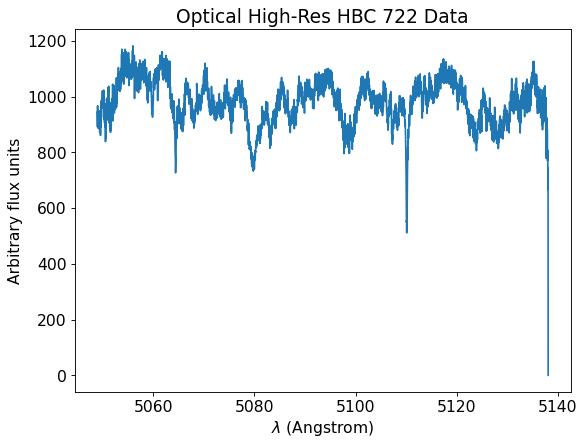

In [18]:
fig=plt.figure(figsize=(8, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(wave_DATA, flux_DATA)
plt.title('Optical High-Res HBC 722 Data')
plt.xlabel(r'$\lambda$ (Angstrom)')
plt.ylabel('Arbitrary flux units')
plt.show()

### Good plotting ranges:

ccd 1: order 3, 5, 7, 8, 9

ccd 2: order 2, 3, 

## Plotting Full FU Ori Model with Data

Recall:
$$F = \dfrac{L^\text{TOT}\cos i}{2\pi d^2}$$

In [192]:
del gaia17bpi_env.disk_atm[0]

IndexError: list assignment index out of range

In [193]:
ATM_GRAVS = 1.5
ROT_VEL = 70*1e5

In [194]:
gaia17bpi_env.createDiskAtm(8000, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)
gaia17bpi_env.createDiskAtm(7000, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)
gaia17bpi_env.createDiskAtm(6000, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)
gaia17bpi_env.createDiskAtm(5000, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)
gaia17bpi_env.createDiskAtm(4000, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)
gaia17bpi_env.createDiskAtm(3500, ATM_GRAVS, ROT_VEL, DIREC, ATM_TABLE)

Used stellar atmosphere at T = 8000.
Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3500.


In [195]:
gaia17bpi_env.createRotStar(temp = 7000, r_star = 2*R_SUN, m_star = 1*M_SUN, inc = 60, \
                            a_v = 3.52, dist = DIST, grav = 4.0, direc = DIREC, atm_table=ATM_TABLE)

Used stellar atmosphere at T = 7000.


## Full-resolution models and data

In [197]:
START = 5050
END = 5150

# Full model
wav_full, lum_full = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, False)

# Single atmosphere
# wav_ATM, lum_ATM = gaia17bpi_env.disk_atm[3].wavelengths_interp, gaia17bpi_env.disk_atm[3].lums_broad

flux_full  = pyasl.unred(wav_full, lum_full*np.cos(gaia17bpi_env.fuori[0].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[0].a_v/3.1)
# flux_ATM  = pyasl.unred(wav_ATM, lum_ATM*np.cos(gaia17bpi_env.fuori[0].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[0].a_v/3.1)



### Normalizing Continuum

In [198]:
from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)

In [199]:
def getNormalizedSpectrum(wav, flux, smooth_factor, norm_range):
    spec_unit = u.erg / (u.cm ** 2 * u.s * u.Angstrom)
    spec = Spectrum1D(flux = flux*spec_unit, spectral_axis = wav*u.Angstrom)
    if smooth_factor:
        spec = box_smooth(spec, width=smooth_factor)
    if norm_range:
        fit_test = fit_continuum(spec, window=norm_range)
    else:
        fit_test = fit_generic_continuum(spec)
    flux_continuum = fit_test(wav*u.Angstrom)
    return spec.flux, flux_continuum, spec.flux/flux_continuum

In [200]:
flux_full_orig, flux_full_cont, flux_full_norm = getNormalizedSpectrum(wav_full, flux_full, None, None)

## Plotting Routine

In [201]:
atms_waves = []
atms_fluxes_orig, atms_fluxes_cont, atms_fluxes_norm = [], [], []

In [202]:
for i in range(len(gaia17bpi_env.disk_atm)):
    wav_ATM, lum_ATM = gaia17bpi_env.disk_atm[i].wavelengths_interp, gaia17bpi_env.disk_atm[i].lums_broad*1e-32
    lum_ATM_orig, lum_ATM_cont, lum_ATM_norm = getNormalizedSpectrum(wav_ATM, lum_ATM, smooth_factor=0, 
                                                                      norm_range = None)
    
    atms_waves.append(wav_ATM)
    atms_fluxes_orig.append(lum_ATM_orig)
    atms_fluxes_cont.append(lum_ATM_cont)
    atms_fluxes_norm.append(lum_ATM_norm)
    
    print(gaia17bpi_env.disk_atm[i].temp)

8000
7000
6000
5000
4000
3500


In [203]:
disk_waves = []
disk_fluxes_orig, disk_fluxes_cont, disk_fluxes_norm = [], [], []

In [204]:
for i in range(len(gaia17bpi_env.fuori)):
    wav_full, lum_full = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', i, True, False)
    flux_full  = pyasl.unred(wav_full, lum_full*np.cos(gaia17bpi_env.fuori[i].inc)/(2*np.pi*DIST**2), 
                             -gaia17bpi_env.fuori[i].a_v/3.1)

    lum_orig, lum_cont, lum_norm = getNormalizedSpectrum(wav_full, flux_full, smooth_factor=0, 
                                                                      norm_range = None)
    
    disk_waves.append(wav_full)
    disk_fluxes_orig.append(lum_orig)
    disk_fluxes_cont.append(lum_cont)
    disk_fluxes_norm.append(lum_norm)
    

In [205]:
spec_unit = u.erg / (u.cm ** 2 * u.s * u.Angstrom)
spectrum_DATA = Spectrum1D(flux = flux_DATA*spec_unit, spectral_axis = wave_DATA*u.Angstrom)
spectrum_DATA = box_smooth(spectrum_DATA, width=10)

In [206]:
# getNormalizedSpectrum(wave_DATA, spectrum_DATA.flux, smooth_factor=0, norm_range=[(6110*u.Angstrom, 6150*u.Angstrom)])

In [207]:
wave_DATA[50:70]

array([5050.02209201, 5050.04408961, 5050.06608721, 5050.0880848 ,
       5050.1100824 , 5050.13208   , 5050.15407759, 5050.17607519,
       5050.19807279, 5050.22007039, 5050.24206798, 5050.26406558,
       5050.28606318, 5050.30806078, 5050.33005837, 5050.35205597,
       5050.37405357, 5050.39605117, 5050.41804876, 5050.44004636])

In [208]:
f_renorm_orig, f_renorm_cont, f_renorm_norm = getNormalizedSpectrum(wave_DATA, spectrum_DATA.flux*1e-12, None, [START*u.Angstrom, END*u.Angstrom])

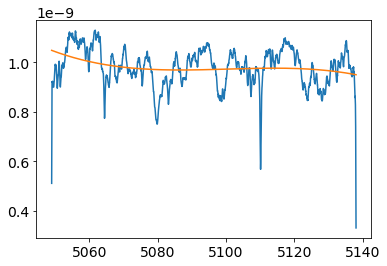

In [209]:
plt.plot(wave_DATA, f_renorm_orig)
plt.plot(wave_DATA, f_renorm_cont)

### Plotting

In [210]:
data_resamp = spectres.spectres(wave_DATA, disk_waves[0], disk_fluxes_norm[0])
data_resamp1 = spectres.spectres(wave_DATA, disk_waves[1], disk_fluxes_norm[1])


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



In [217]:
PLT_START = 5053
PLT_END = 5137

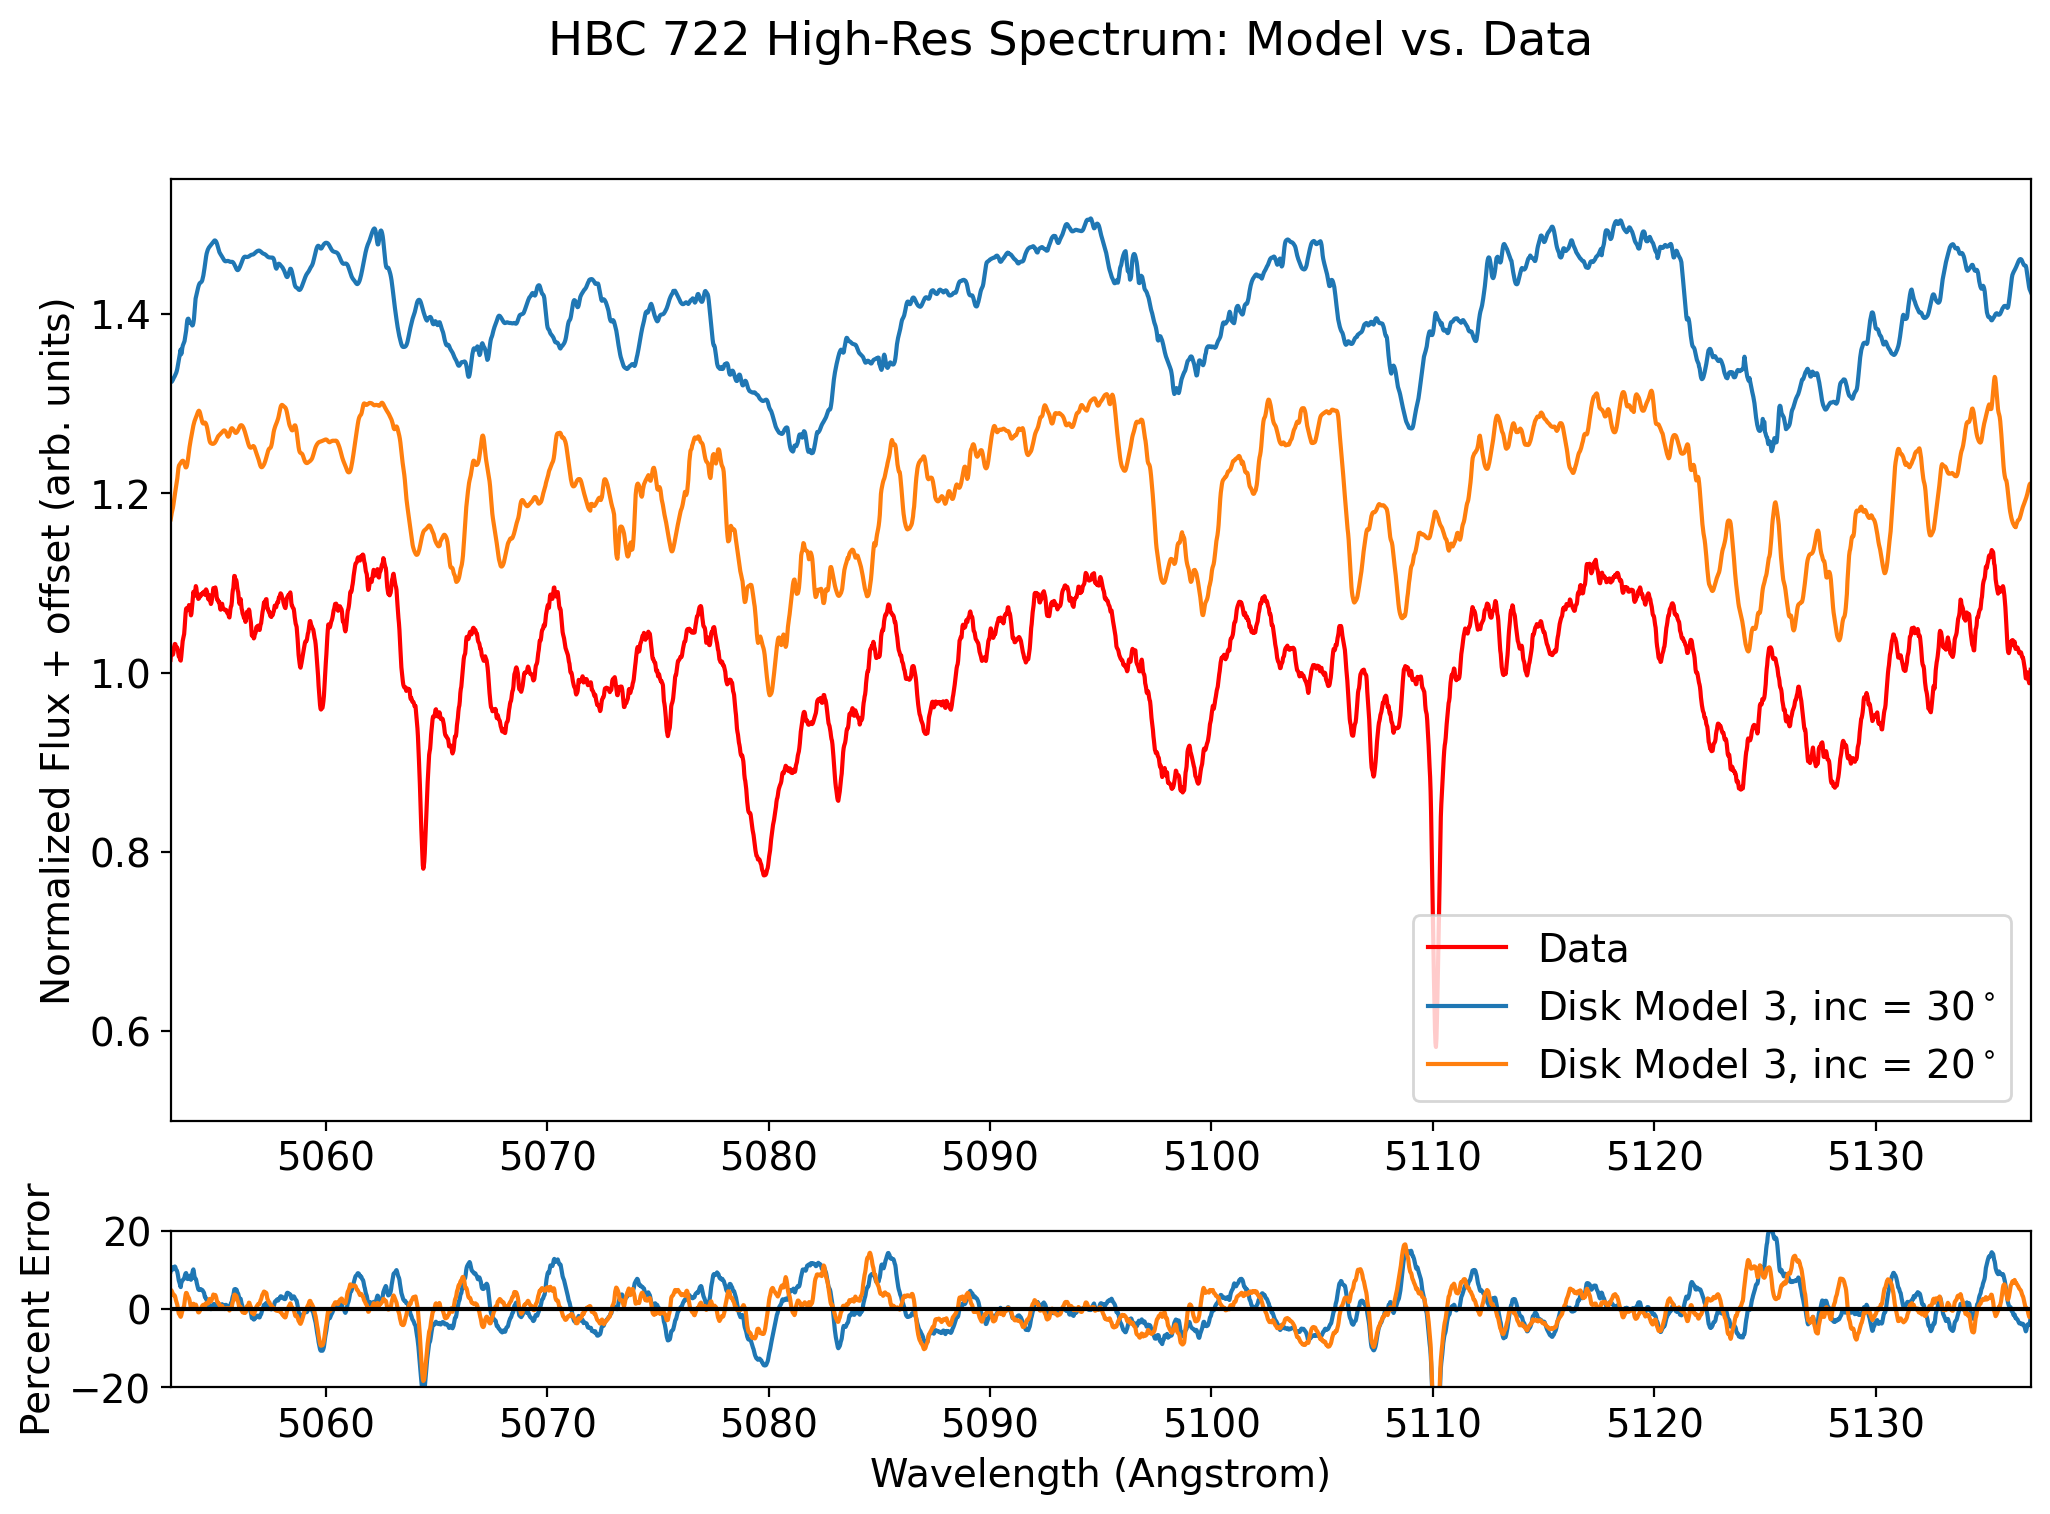

In [220]:
fig=plt.figure(figsize=(12, 8), dpi= 200)
gs = gridspec.GridSpec(2, 1,height_ratios=[6,1])


ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# plt.plot(wave_DATA, f_renorm_orig*1e9/1., color='red', label = 'Data')
ax.plot(wave_DATA, f_renorm_norm, color='red', label = 'Data')

ax.plot(disk_waves[0], disk_fluxes_norm[0] + 0.4*np.ones(len(disk_fluxes_norm[0])), label='Disk Model 3, inc = $30^\circ$')
ax.plot(disk_waves[1], disk_fluxes_norm[1] + 0.2*np.ones(len(disk_fluxes_norm[0])), label=r'Disk Model 3, inc = $20^\circ$')
# ax.plot(disk_waves[2], disk_fluxes_norm[2] + 0.23*np.ones(len(disk_fluxes_norm[0])), label='Disk Model 2a')


ax2.plot(wave_DATA, 100*(f_renorm_norm - data_resamp)/data_resamp)
ax2.plot(wave_DATA, 100*(f_renorm_norm - data_resamp1)/data_resamp1)



ax.set_xlim(PLT_START, PLT_END)
ax2.set_xlim(PLT_START, PLT_END)
ax2.plot(wave_DATA, np.zeros(len(wave_DATA)), 'k')
ax2.set_ylim(-20, 20)



ax.set_ylim(0.5, 1.55)

ax.legend(loc='lower right')
ax.set_ylabel('Normalized Flux + offset (arb. units)')
ax2.set_xlabel('Wavelength (Angstrom)')
plt.suptitle('HBC 722 High-Res Spectrum: Model vs. Data')
ax2.set_ylabel('Percent Error')

# plt.savefig('hbc722_hires_optical.png', dpi = 200, bbox_inches='tight')

plt.show()